In [5]:
import gc
import joblib
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score

# 收集記憶體
gc.collect()

# 載入數據
random_state = 42
df = pd.read_feather('combined.feather')

# 特徵選擇
x_col = [col for col in df.columns if '技術指標' in col]
X = df[x_col]
y = df['飆股']
print(f"訓練資料維度：{X.shape}, 目標欄位：{y.shape}")

# 測試資料與提交模板
pub_df = pd.read_feather('pub_x.feather')
base_submit = pd.read_csv('38_Public_Test_Set_and_Submmision_Template_V2/38_Public_Test_Set_and_Submmision_Template_V2/submission_template_public.csv')

# 逐個 seed 嘗試不同資料切法
for seed in range(0, 10):
    print(f"\n==== Training with random seed: {seed} ====\n")
    
    # 切分資料
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )

    # 建立資料池
    train_pool = Pool(data=X_train, label=y_train)
    test_pool = Pool(data=X_test, label=y_test)

    # 建立 CatBoost 模型（強化抗過擬合參數）
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='F1',
        task_type='GPU',
        devices='0',
        verbose=100,
        #class_weights={0: 1, 1: 10},
        l2_leaf_reg=5,
        random_strength=1,
        #bagging_temperature=0.8,
        subsample=0.8,
        max_ctr_complexity=4,
        grow_policy='Lossguide',
        bootstrap_type='Bernoulli',
        od_type='Iter',
        od_wait=50
    )

    # 訓練
    model.fit(train_pool, eval_set=test_pool)

    # 預測
    submit = base_submit.copy()
    submit['飆股'] = model.predict_proba(pub_df[x_col])[:, 1]
    submit_path = f'submit_{random_state}_{seed}.csv'
    submit.to_csv(submit_path, index=False)
    print('f1_score',f1_score(y_test,model.predict(X_test)))
    print(f"✔️ 儲存提交檔案：{submit_path}")

    # 清除資源，釋放GPU記憶體
    del model, train_pool, test_pool, submit
    gc.collect()


訓練資料維度：(2508, 81), 目標欄位：(2508,)

==== Training with random seed: 0 ====

0:	learn: 0.9528068	test: 0.9069767	best: 0.9069767 (0)	total: 312ms	remaining: 5m 11s
bestTest = 0.9310344828
bestIteration = 27
Shrink model to first 28 iterations.
f1_score 0.9310344827586207
✔️ 儲存提交檔案：submit_42_0.csv

==== Training with random seed: 1 ====

0:	learn: 0.9597645	test: 0.8832685	best: 0.8832685 (0)	total: 16.7ms	remaining: 16.7s
100:	learn: 1.0000000	test: 0.9112426	best: 0.9137255 (66)	total: 1.86s	remaining: 16.6s
bestTest = 0.9137254902
bestIteration = 66
Shrink model to first 67 iterations.
f1_score 0.9137254901960784
✔️ 儲存提交檔案：submit_42_1.csv

==== Training with random seed: 2 ====

0:	learn: 0.9586207	test: 0.9066148	best: 0.9066148 (0)	total: 24.1ms	remaining: 24.1s
100:	learn: 1.0000000	test: 0.9338521	best: 0.9418605 (82)	total: 1.87s	remaining: 16.6s
bestTest = 0.9418604651
bestIteration = 82
Shrink model to first 83 iterations.
f1_score 0.9418604651162791
✔️ 儲存提交檔案：submit_42_2.csv

===

In [73]:
submit['飆股'] = submit['飆股'].apply(lambda x: 1 if x >= 0.5 else 0)
submit['飆股'].value_counts()

飆股
0    24780
1      328
Name: count, dtype: int64

In [74]:
submit.to_csv(f'submit_{i}.csv',index=False)

1. 技術指標_RSI(10): 23.5413
2. 技術指標_季K(9): 13.5431
3. 技術指標_月RSI(10): 10.6961
4. 外資券商_前16天分點成交力(%): 6.4363
5. 技術指標_Alpha(250D): 6.0148
6. 個股19天乖離率: 5.3877
7. 賣超第6名分點前4天買均價: 4.9061
8. 買超第8名分點前5天買筆數: 4.1041
9. 技術指標_RSI(5): 3.9994
10. 技術指標_週RSI(10): 3.8634
11. 買超第15名分點前19天賣均張: 3.5895
12. 賣超第2名分點前1天張增減: 3.1711
13. 上市加權指數前15天收盤價: 3.0055
14. 技術指標_週-DI(14): 1.6585
15. 上市加權指數前11天收盤價: 1.2936
16. 上市加權指數前14天收盤價: 1.2597
17. 上市加權指數前1天收盤價: 1.2164
18. 技術指標_乖離率(250日): 0.9431
19. 買超第6名分點前14天買均值(千): 0.7059
20. 個股券商分點籌碼分析_近60日買進分佈係數: 0.6646
21. 買超第4名分點前6天買金額(千): 0.0000
22. 買超第3名分點前6天買均值(千): 0.0000
23. 買超第4名分點前6天賣金額(千): 0.0000
24. 買超第5名分點前6天買均價: 0.0000
25. 買超第3名分點前6天賣均值(千): 0.0000
26. 買超第4名分點前6天賣張: 0.0000
27. 買超第4名分點前6天買張: 0.0000
28. 買超第4名分點前6天買筆數: 0.0000
29. 買超第4名分點前6天張增減: 0.0000
30. 買超第4名分點前6天券商代號: 0.0000


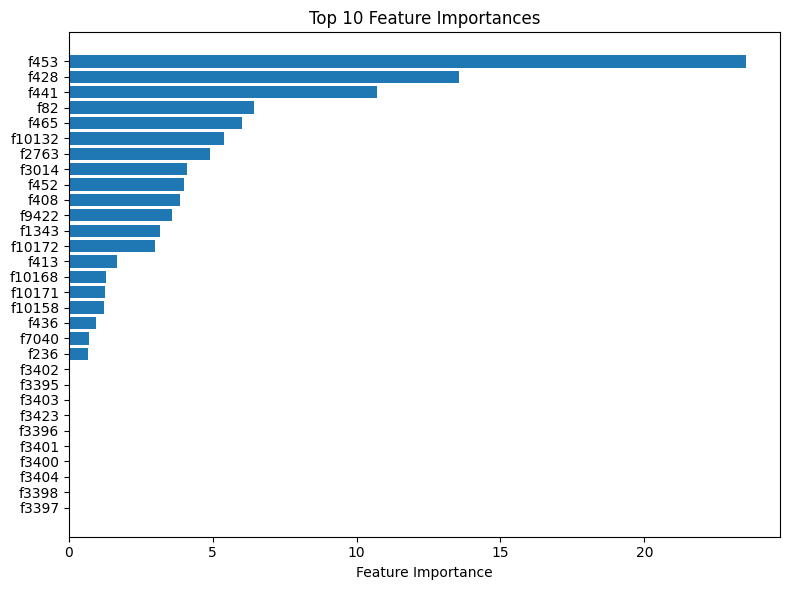

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# 取得特徵重要度
importances = model.get_feature_importance()

# 假設你沒有 feature names，就用預設 f0, f1, f2...
feature_names = [f"f{i}" for i in range(len(importances))]

# 取得前10名的重要度與名稱
top_n = 30
indices = np.argsort(importances)[::-1][:top_n]  # 由大到小排序
top_features = [feature_names[i] for i in indices]
top_importances = importances[indices]
# 顯示數值
f = []
for i, (name, score) in enumerate(zip(top_features, top_importances)):
    print(f"{i+1}. {x_col[int(name[1:])]}: {score:.4f}")
    f.append(x_col[int(name[1:])])

# 繪圖
plt.figure(figsize=(8, 6))
plt.barh(range(top_n), top_importances[::-1], align='center')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

In [76]:
import joblib
joblib.dump(f,f'f_{seed}.pkl')

['f_1.pkl']

In [77]:
1. 技術指標_月RSI(10): 22.1459
2. 技術指標_RSI(10): 21.9069
3. 技術指標_週RSI(5): 16.9871
4. 上市加權指數前6天收盤價: 16.3336
5. 賣超第2名分點前12天賣金額(千): 13.2845
6. 賣超第11名分點賣張: 9.3421
7. 買超第4名分點前6天買金額(千): 0.0000
8. 買超第4名分點前6天買均價: 0.0000
9. 買超第4名分點前6天賣均張: 0.0000
10. 買超第4名分點前6天買均張: 0.0000

1. 技術指標_Alpha(250D): 35.0077
2. 技術指標_RSI(5): 33.6154
3. 技術指標_週RSI(10): 12.4511
4. 上市加權指數前8天收盤價: 8.2393
5. 買超第3名分點前2天賣均價: 7.5044
6. 日投信_投信買均價: 3.1822
7. 上市加權指數20天成交量波動度: 0.0000
8. 買超第4名分點前6天買金額(千): 0.0000
9. 買超第4名分點前6天賣均張: 0.0000
10. 買超第4名分點前6天買均張: 0.0000

1. 技術指標_RSI(10): 23.5413
2. 技術指標_季K(9): 13.5431
3. 技術指標_月RSI(10): 10.6961
4. 外資券商_前16天分點成交力(%): 6.4363
5. 技術指標_Alpha(250D): 6.0148
6. 個股19天乖離率: 5.3877
7. 賣超第6名分點前4天買均價: 4.9061
8. 買超第8名分點前5天買筆數: 4.1041
9. 技術指標_RSI(5): 3.9994
10. 技術指標_週RSI(10): 3.8634

1. 賣超第10名分點前20天金額增減(千): 24.7671
2. 技術指標_月RSI(10): 23.2320
3. 技術指標_週RSI(10): 22.2424
4. 技術指標_RSI(5): 14.9667
5. 買超第10名分點前8天張增減: 8.6892
6. 賣超第5名分點前6天買張: 6.1025
7. 上市加權指數20天成交量波動度: 0.0000
8. 買超第4名分點前6天買張: 0.0000
9. 買超第4名分點前6天賣筆數: 0.0000
10. 買超第4名分點前6天買筆數: 0.0000

# 發現RSI有用
# 先篩RSI

SyntaxError: invalid decimal literal (3114100038.py, line 12)